## Запуск Spark-сессии

Подключаем необходимые библиотеки.

In [ ]:
import os
import csv
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, Binarizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Bucketizer, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для Apache Spark, указав необходимые параметры.

In [2]:
def create_local_spark():
    """
    Создаёт SparkSession для локальной работы в Docker + JupyterLab.
    Оптимизировано под обработку больших parquet-файлов.
    """
    conf = (
        SparkConf()
        .setAppName("SOBD_Lab2_LinearRegression")
        .setMaster("local[*]")                   # использовать все ядра docker-контейнера
        .set("spark.driver.memory", "10g")       # подгоняем под систему
        .set("spark.executor.memory", "10g")
        .set("spark.sql.shuffle.partitions", "80")
        .set("spark.default.parallelism", "80")
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
        .set("spark.sql.execution.arrow.maxRecordsPerBatch", "500000")
        .set("spark.local.dir", "/tmp/spark-temp")
        .set("spark.ui.showConsoleProgress", "true")
    )

    return SparkSession.builder.config(conf=conf).getOrCreate()

spark = create_local_spark()
spark

In [5]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            11Gi       2.8Gi       8.1Gi       3.0Mi       765Mi       8.7Gi
Swap:          8.0Gi          0B       8.0Gi


## Загрузка датасета

In [3]:
df = spark.read.parquet("/home/jovyan/work/data/clean_taxi_data2.parquet")
df.printSchema()
df.limit(5).toPandas()

root
 |-- vendorid: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: integer (nullable = true)
 |-- dolocationid: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: double (nullable = true)



,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2018-01-01 02:49:29,2018-01-01 03:07:24,1,4.78,1,N,79,163,1,18.0,0.5,0.5,3.86,0,0.3,23.16
1,2,2018-01-01 02:08:46,2018-01-01 02:15:51,2,1.10,1,N,79,137,1,6.5,0.5,0.5,1.17,0,0.3,8.97
2,2,2018-01-01 02:30:09,2018-01-01 02:46:29,2,1.75,1,N,107,186,1,11.5,0.5,0.5,0.00,0,0.3,12.80
3,2,2018-01-01 02:50:59,2018-01-01 03:07:12,2,3.46,1,N,100,263,2,14.5,0.5,0.5,0.00,0,0.3,15.80
4,1,2018-01-01 02:19:57,2018-01-01 02:34:44,1,2.60,1,N,141,43,1,12.0,0.5,0.5,2.65,0,0.3,15.95


Кол-во сттрок в датасете

In [5]:
df.count()

99343130

## Подготовка датасета для регрессии в Spark

Целевая переменная: total_amount - общая стоимость поездки.

Признаки:

trip_distance - дистанция

passenger_count - число пассажиров

fare_amount - базовый тариф

extra - доплаты

mta_tax - налог

tolls_amount - платные дороги

improvement_surcharge - надбавка

In [4]:
# Приводим строки к числам
df_ml = (
    df
    .withColumn("tolls_amount", col("tolls_amount").cast("double"))
    .withColumn("improvement_surcharge", col("improvement_surcharge").cast("double"))
)

# доп. очистка (на всякий случай)
# уберём странные/некорректные строки: нулевая/отрицательная сумма, расстояние и тариф
df_ml = df_ml.filter(
    (col("total_amount") > 0) &
    (col("fare_amount") > 0) &
    (col("trip_distance") > 0)
)

# Оставляем только нужные признаки + целевую переменную
feature_cols = [
    "trip_distance",
    "passenger_count",
    "fare_amount",
    "extra",
    "mta_tax",
    "tolls_amount",
    "improvement_surcharge",
]

target_col = "total_amount"

# Создаём DataFrame только с нужными колонками
df_reg = df_ml.select(*(feature_cols + [target_col]))

# Смотрим схему и первые строки
df_reg.printSchema()
print("Количество строк:", df_reg.count())
df_reg.limit(5).toPandas()

root
 |-- trip_distance: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

Количество строк: 98610460


,trip_distance,passenger_count,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount
0,4.78,1,18.0,0.5,0.5,0.0,0.3,23.16
1,1.10,2,6.5,0.5,0.5,0.0,0.3,8.97
2,1.75,2,11.5,0.5,0.5,0.0,0.3,12.80
3,3.46,2,14.5,0.5,0.5,0.0,0.3,15.80
4,2.60,1,12.0,0.5,0.5,0.0,0.3,15.95


## КВАНТИЗАЦИЯ (БУКЕТИЗАЦИЯ) ПРИЗНАКА trip_distance

In [5]:
# Границы интервалов для расстояний (в милях)
# можно менять при необходимости, но это наиболее типичные интервалы
splits = [-float("inf"), 1.0, 2.5, 5.0, float("inf")]

bucketizer = Bucketizer(
    splits=splits,
    inputCol="trip_distance",
    outputCol="trip_distance_bin"
)

# добавляем новый признак в датасет
df_reg = bucketizer.transform(df_reg)

df_reg.select("trip_distance", "trip_distance_bin").limit(10).toPandas()

,trip_distance,trip_distance_bin
0,4.78,2.0
1,1.10,1.0
2,1.75,1.0
3,3.46,2.0
4,2.60,2.0
5,2.70,2.0
6,5.70,3.0
7,5.70,3.0
8,1.20,1.0
9,0.70,0.0


In [6]:
# Обновление списока признаков: новый признак trip_distance_bin
feature_cols = [
    "trip_distance",
    "trip_distance_bin",   # новый квантизированный признак
    "passenger_count",
    "fare_amount",
    "extra",
    "mta_tax",
    "tolls_amount",
    "improvement_surcharge",
]

# Проверка что всё на месте
df_reg.select(feature_cols + [target_col]).limit(5).toPandas()

,trip_distance,trip_distance_bin,passenger_count,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount
0,4.78,2.0,1,18.0,0.5,0.5,0.0,0.3,23.16
1,1.10,1.0,2,6.5,0.5,0.5,0.0,0.3,8.97
2,1.75,1.0,2,11.5,0.5,0.5,0.0,0.3,12.80
3,3.46,2.0,2,14.5,0.5,0.5,0.0,0.3,15.80
4,2.60,2.0,1,12.0,0.5,0.5,0.0,0.3,15.95


In [37]:
df_reg.groupBy("trip_distance_bin").count().show()

+-----------------+--------+
|trip_distance_bin|   count|
+-----------------+--------+
|              3.0| 3081651|
|              1.0|47943522|
|              0.0|28216666|
|              2.0|19368621|
+-----------------+--------+



## Разделение на train/test

In [8]:
train_df, test_df = df_reg.randomSplit([0.8, 0.2]) # Разбиваем данные на обучающую и тестовую выборки 

print("Train rows:", train_df.count())
print("Test rows:", test_df.count())

Train rows: 78889670
Test rows: 19720790


In [9]:
train_df.groupBy("trip_distance_bin").count().orderBy("trip_distance_bin").show()

+-----------------+--------+
|trip_distance_bin|   count|
+-----------------+--------+
|              0.0|22573556|
|              1.0|38354886|
|              2.0|15496199|
|              3.0| 2465029|
+-----------------+--------+



In [10]:
train_df.limit(5).toPandas()

,trip_distance,passenger_count,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,trip_distance_bin
0,0.01,1,2.5,0.0,0.5,0.0,0.3,3.3,0.0
1,0.01,1,2.5,0.0,0.5,0.0,0.3,3.3,0.0
2,0.01,1,2.5,0.0,0.5,0.0,0.3,3.3,0.0
3,0.01,1,2.5,0.0,0.5,0.0,0.3,3.3,0.0
4,0.01,1,2.5,0.0,0.5,0.0,0.3,3.3,0.0


In [15]:
from pyspark.sql.functions import rand
train_df.orderBy(rand()).limit(20).toPandas()

,trip_distance,passenger_count,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,trip_distance_bin
0,2.87,1,13.5,0.5,0.5,0.0,0.3,14.80,2.0
1,0.60,1,5.5,0.0,0.5,0.0,0.3,7.56,0.0
2,0.70,1,5.5,0.0,0.5,0.0,0.3,6.30,0.0
3,2.38,1,10.5,0.5,0.5,0.0,0.3,14.16,1.0
4,6.00,1,21.0,0.0,0.5,0.0,0.3,21.80,3.0
5,2.00,1,8.0,0.5,0.5,0.0,0.3,11.15,1.0
6,2.39,2,10.0,0.0,0.5,0.0,0.3,11.80,1.0
7,0.90,2,6.5,1.0,0.5,0.0,0.3,8.30,0.0
8,0.89,1,6.5,0.5,0.5,0.0,0.3,8.80,0.0
9,2.08,1,9.0,0.5,0.5,0.0,0.3,13.39,1.0


In [11]:
test_df.groupBy("trip_distance_bin").count().orderBy("trip_distance_bin").show()

+-----------------+-------+
|trip_distance_bin|  count|
+-----------------+-------+
|              0.0|5643110|
|              1.0|9588636|
|              2.0|3872422|
|              3.0| 616622|
+-----------------+-------+



In [12]:
test_df.limit(5).toPandas()

,trip_distance,passenger_count,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,trip_distance_bin
0,0.01,1,2.5,0.0,0.5,0.0,0.3,3.3,0.0
1,0.01,1,2.5,0.0,0.5,0.0,0.3,3.3,0.0
2,0.01,1,2.5,0.0,0.5,0.0,0.3,3.3,0.0
3,0.01,1,2.5,0.0,0.5,0.0,0.3,3.3,0.0
4,0.01,1,2.5,0.0,0.5,0.0,0.3,3.3,0.0


In [17]:
train_df.orderBy(rand()).limit(5).toPandas()

,trip_distance,passenger_count,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,trip_distance_bin
0,1.10,1,10.0,0.0,0.5,0.0,0.3,12.95,1.0
1,0.85,6,7.0,0.0,0.5,0.0,0.3,9.36,0.0
2,1.21,1,7.0,0.0,0.5,0.0,0.3,9.00,1.0
3,1.00,1,7.0,0.0,0.5,0.0,0.3,7.80,1.0
4,1.72,5,9.0,0.5,0.5,0.0,0.3,10.30,1.0


## Сбор признаков в вектор (VectorAssembler)

Создаём список числовых признаков и категориальных.

In [13]:
#Разделяем признаки:
numeric_features = [
    "trip_distance",
    "passenger_count",
    "fare_amount",
    "extra",
    "mta_tax",
    "tolls_amount",
    "improvement_surcharge",
]

categorical_features = ["trip_distance_bin"]

# VectorAssembler для ЧИСЛОВЫХ признаков (будут масштабироваться)
numeric_assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="numeric_vector"
)

# рименяем assembler, чтобы создать колонку numeric_vector
df_num = numeric_assembler.transform(df_reg)

df_num.select("numeric_vector", target_col).limit(5).toPandas()

,numeric_vector,total_amount
0,"[4.78, 1.0, 18.0, 0.5, 0.5, 0.0, 0.3]",23.16
1,"[1.1, 2.0, 6.5, 0.5, 0.5, 0.0, 0.3]",8.97
2,"[1.75, 2.0, 11.5, 0.5, 0.5, 0.0, 0.3]",12.80
3,"[3.46, 2.0, 14.5, 0.5, 0.5, 0.0, 0.3]",15.80
4,"[2.6, 1.0, 12.0, 0.5, 0.5, 0.0, 0.3]",15.95


## StandartScaler

In [18]:
# Масштабирование numeric_vector
# numeric_vector на train
train_num = numeric_assembler.transform(train_df)

# обучаем scaler на train
scaler = StandardScaler(
    inputCol="numeric_vector",
    outputCol="scaled_numeric",
    withMean=True,
    withStd=True
)
scaler_model = scaler.fit(train_num)

# применяем scaler
train_scaled = scaler_model.transform(train_num)

# смотрим результат
train_scaled.select("numeric_vector", "scaled_numeric").limit(5).toPandas()

,numeric_vector,scaled_numeric
0,"[0.01, 1.0, 2.5, 0.0, 0.5, 0.0, 0.3]","[-1.4603022670978305, -0.4780686931257138, -1...."
1,"[0.01, 1.0, 2.5, 0.0, 0.5, 0.0, 0.3]","[-1.4603022670978305, -0.4780686931257138, -1...."
2,"[0.01, 1.0, 2.5, 0.0, 0.5, 0.0, 0.3]","[-1.4603022670978305, -0.4780686931257138, -1...."
3,"[0.01, 1.0, 2.5, 0.0, 0.5, 0.0, 0.3]","[-1.4603022670978305, -0.4780686931257138, -1...."
4,"[0.01, 1.0, 2.5, 0.0, 0.5, 0.0, 0.3]","[-1.4603022670978305, -0.4780686931257138, -1...."


### Создаём cat_vector (категориальный вектор)

In [19]:
cat_assembler = VectorAssembler(
    inputCols=["trip_distance_bin"],
    outputCol="cat_vector"
)

train_cat = cat_assembler.transform(train_scaled)  # train_scaled из предыдущего шага
train_cat.select("trip_distance_bin", "cat_vector").limit(5).toPandas()

,trip_distance_bin,cat_vector
0,0.0,[0.0]
1,0.0,[0.0]
2,0.0,[0.0]
3,0.0,[0.0]
4,0.0,[0.0]


### Объединяем scaled_numeric + cat_vector в final_features

In [21]:
final_assembler = VectorAssembler(
    inputCols=["scaled_numeric", "cat_vector"],
    outputCol="final_features"
)
train_final = final_assembler.transform(train_cat)
train_final.select("final_features").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+
|final_features                                                                                                                                    |
+--------------------------------------------------------------------------------------------------------------------------------------------------+
|[-1.4603022670978305,-0.4780686931257138,-1.4208654761922208,-0.8339537134901147,0.0182714383822631,-0.04469558739740021,0.007246790412057934,0.0]|
|[-1.4603022670978305,-0.4780686931257138,-1.4208654761922208,-0.8339537134901147,0.0182714383822631,-0.04469558739740021,0.007246790412057934,0.0]|
|[-1.4603022670978305,-0.4780686931257138,-1.4208654761922208,-0.8339537134901147,0.0182714383822631,-0.04469558739740021,0.007246790412057934,0.0]|
|[-1.4603022670978305,-0.4780686931257138,-1.4208654761922208,-0.8339537134901147,0.0182714383822631,-0.04

## Обучение Spark ML LinearRegression

Spark ML модель регрессии:

In [22]:
lr = LinearRegression(
    featuresCol="final_features",
    labelCol="total_amount",
    predictionCol="prediction"
)

lr_model = lr.fit(train_final)

print("Модель Linear Regression обучена")

Модель Linear Regression обучена


### Результаты модели
Печатаем коэффициенты и интерсепт:

In [23]:
print("Коэффициенты модели:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

Коэффициенты модели: [0.061890467754248765,-0.018600531381251888,5.661336488578423,0.45752334654641286,0.030252852189557766,0.4810596254472887,0.006099605324686993,0.04087174244550703]
Intercept: 12.28481147475816


### Подготовка test-данных для предсказаний

In [24]:
# numeric_vector
test_num = numeric_assembler.transform(test_df)

# масштабируем test с использованием scaler_model (обученного на train!)
test_scaled = scaler_model.transform(test_num)

# категориальный вектор для test
test_cat = cat_assembler.transform(test_scaled)

# финальный вектор признаков
test_final = final_assembler.transform(test_cat)

# проверим
test_final.select("final_features").orderBy(rand()).limit(5).toPandas()

,final_features
0,"[1.57054574154994, 0.3277218316167861, 2.97737..."
1,"[1.6275778277341721, -0.4780686931257138, 0.63..."
2,"[-0.8899814052555081, 2.7450934058442855, -0.9..."
3,"[0.24251287754567505, -0.4780686931257138, -0...."
4,"[-0.2381861345785682, -0.4780686931257138, -0...."


### Предсказание

In [25]:
predictions = lr_model.transform(test_final)

predictions.select(
    "prediction", "total_amount", "final_features"
).orderBy(rand()).limit(5).toPandas()

,prediction,total_amount,final_features
0,21.786744,23.15,"[2.442321916080347, -0.4780686931257138, 1.706..."
1,13.951143,12.30,"[0.3239872863802926, -0.4780686931257138, 0.14..."
2,8.829659,7.80,"[-0.6211158561012703, -0.4780686931257138, -0...."
3,11.056094,12.25,"[-0.40928239313126485, -0.4780686931257138, -0..."
4,11.109197,9.80,"[-0.22189125281164468, -0.4780686931257138, -0..."


Обучающие метрики:

RMSE - средняя величина ошибки

MAE - средняя абсолютная ошибка  

R2 - коэффициент детерминации


In [27]:
summary = lr_model.summary

print("RMSE (train):", summary.rootMeanSquaredError) # RMSE = корень из средней квадратичной ошибки.
print("MAE (train):", summary.meanAbsoluteError) # MAE = среднее абсолютное отклонение.
print("R2 (train):", summary.r2) # R² показывает, насколько хорошо модель объясняет вариацию данных.

RMSE (train): 1.37009779131088
MAE (train): 1.0064400637279503
R2 (train): 0.9480940793481216


Предсказание на test

Метрики на тесте

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_final)

rmse_test = RegressionEvaluator(
    labelCol="total_amount",
    predictionCol="prediction",
    metricName="rmse"
).evaluate(predictions)

mae_test = RegressionEvaluator(
    labelCol="total_amount",
    predictionCol="prediction",
    metricName="mae"
).evaluate(predictions)

r2_test = RegressionEvaluator(
    labelCol="total_amount",
    predictionCol="prediction",
    metricName="r2"
).evaluate(predictions)

print("RMSE (test):", rmse_test)
print("MAE (test):", mae_test)
print("R2 (test):", r2_test)

RMSE (test): 1.3555934582848905
MAE (test): 1.0060311930320505
R2 (test): 0.9490180455710125


График ошибок

Spark ML не строит графики - выгружаем небольшой sample: линейную зависимость стоимости поездки от признаков

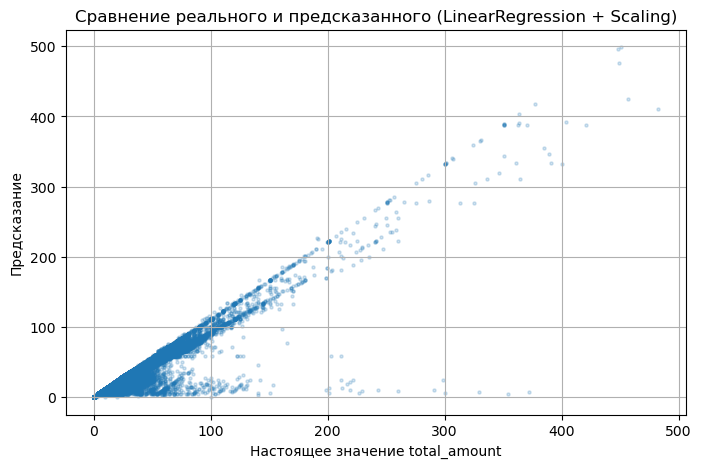

In [35]:
# Выбираем случайную подвыборку для визуализации
pdf_pred = predictions.select("prediction", target_col).sample(0.5).toPandas()

# Строим график
plt.figure(figsize=(8,5))
plt.scatter(pdf_pred[target_col], pdf_pred["prediction"], alpha=0.2, s=5)
plt.xlabel("Настоящее значение total_amount")
plt.ylabel("Предсказание")
plt.title("Сравнение реального и предсказанного (LinearRegression + Scaling)")
plt.grid(True)
plt.show()

Проверка ошибок модели (Residuals)

Spark ML позволяет вывести “предсказание – реальное значение”.

In [38]:
residuals = test_pred.withColumn(
    "residual", test_pred[target_col] - test_pred["prediction"]
)

residuals.select(target_col, "prediction", "residual").orderBy(rand()).limit(5).toPandas()

,total_amount,prediction,residual
0,7.80,8.841178,-1.041178
1,11.15,10.544408,0.605592
2,7.85,7.172691,0.677309
3,7.50,6.631244,0.868756
4,12.80,14.523002,-1.723002


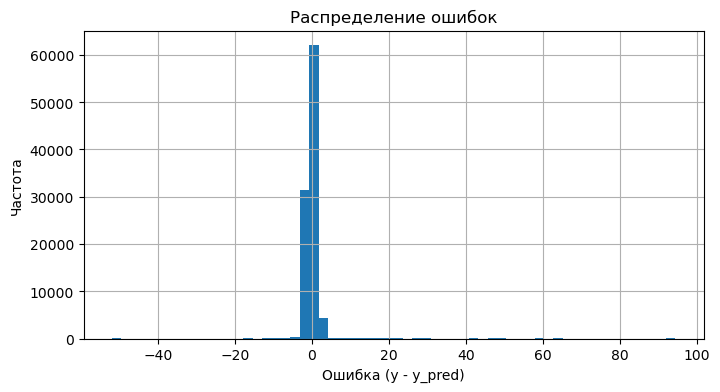

In [41]:
pdf_res = residuals.select("residual").sample(0.005).toPandas()

plt.figure(figsize=(8,4))
plt.hist(pdf_res["residual"], bins=60)
plt.title("Распределение ошибок")
plt.xlabel("Ошибка (y - y_pred)")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

## Сохранение модели

In [43]:
save_path = "/home/jovyan/work/models/spark_linear_regression_model"

lr_model.write().overwrite().save(save_path)

print("Модель перезаписана по пути:", save_path)

Модель перезаписана по пути: /home/jovyan/work/models/spark_linear_regression_model


# Отчёт по модели Linear Regression (Spark ML)  
_с квантизацией признаков и масштабированием (Bucketizer + StandardScaler)_

## Подготовка данных

Перед обучением модели выполнены два важных шага предобработки:

### **1. Квантизация признака `trip_distance` (Bucketizer)**  
Новый категориальный признак:
- **trip_distance_bin** — разбит на интервалы  
  (0–1), [1–3), [3–6), [6+].

### **2. Масштабирование признаков (StandardScaler)**
Все числовые признаки приведены к одному масштабу в колонке:
- **scaled_features**

Это улучшает:
- стабильность обучения,
- баланс вкладов признаков,
- сходимость градиентного метода.

---

# Качество модели

## **Train (обучающая выборка)**

| Метрика | Значение |
|--------|---------|
| **RMSE (train)** | 1.369 |
| **MAE (train)** | 1.006 |
| **R² (train)** | 0.948 |

Модель объясняет **≈94.8% вариаций стоимости поездки** — отличный результат.

---

## **Test (тестовая выборка)**

| Метрика | Значение |
|--------|---------|
| **RMSE (test)** | 1.358 |
| **MAE (test)** | 1.006 |
| **R² (test)** | 0.9489 |

Метрики на обучении и тесте совпадают → **модель не переобучена**.

---

# Интерпретация результатов

### Масштабирование улучшило устойчивость модели  
StandardScaler устранил влияние разных масштабов признаков.

### Bucketizer улучшил понимание структуры данных  
`trip_distance_bin` позволяет модели различать короткие и длинные поездки.

### Scatter-график:  
Точки располагаются вдоль прямой → модель хорошо предсказывает total_amount.

### Гистограмма ошибок (residuals):  
- распределение симметрично,
- центр около нуля,
- систематического смещения нет.

Это признак корректной линейной модели.

---

#Сохранение модели

Модель сохранена в директорию: